In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau


In [6]:
import os  # Provides functions for interacting with the operating system
import cv2  # OpenCV library for image and video processing
import torch  # PyTorch library for deep learning
import imghdr  # Used to determine the type of image contained in a file
import torchvision  # PyTorch library for vision-related tasks
import numpy as np  # Fundamental package for scientific computing with Python
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # TensorFlow library for deep learning
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations
from sklearn.utils import shuffle # For shuffling dataset
from tensorflow.keras import layers  # Core Keras layers API
from tensorflow.keras.models import Sequential  # Sequential model API in Keras
from tensorflow.keras.optimizers import RMSprop  # RMSprop optimizer
from tensorflow.keras.applications import VGG16 # Import pre-trained VGG16 model for feature extraction
from tensorflow.keras.applications.vgg16 import preprocess_input # Function to preprocess input images for VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for image data
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy  # Metrics for model evaluation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  # Core layers for building CNN models

In [7]:
#Importing our datasets
data_dir = '/kaggle/input/test-sample/filtered aug dataset'

In [8]:
#Building Data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 11460 files belonging to 2 classes.


In [10]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
len(data)

359

In [12]:
#resizing shape to none,224,224,3
import tensorflow as tf

# Assuming `dataset` is your original dataset with images of shape (256, 256, 3)
target_height, target_width = 224, 224

def resize_images(image, label):
    # Resize the image to the desired shape
    image = tf.image.resize(image, [target_height, target_width])
    return image, label

# Apply the resizing transformation to the dataset
data = data.map(resize_images)


In [13]:
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
len(data)

359

In [15]:
# Converting the dataset to an iterator
data_iterator = data.as_numpy_iterator()

# Acessing a batch from the Datapipeline
batch = data_iterator.next()
len(batch)

2

In [16]:
# Displaying the shape of the batch
batch[0].shape

(32, 224, 224, 3)

In [17]:
# Displaying the class labels
#Class 1 = Normal
#Class 0 = Down
batch[1]

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1], dtype=int32)

In [18]:
# Display the shape of the image batch
print(batch[0].shape)  # Should be (batch_size, height, width, channels)

# Display the labels
print(batch[1])  # Array of labels corresponding to the batch

(32, 224, 224, 3)
[1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1]


In [19]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1])
print(df_features)

    0
0   1
1   1
2   0
3   1
4   1
5   1
6   1
7   0
8   0
9   1
10  0
11  0
12  0
13  1
14  0
15  1
16  0
17  0
18  0
19  1
20  0
21  0
22  0
23  0
24  1
25  1
26  0
27  1
28  0
29  1
30  0
31  1


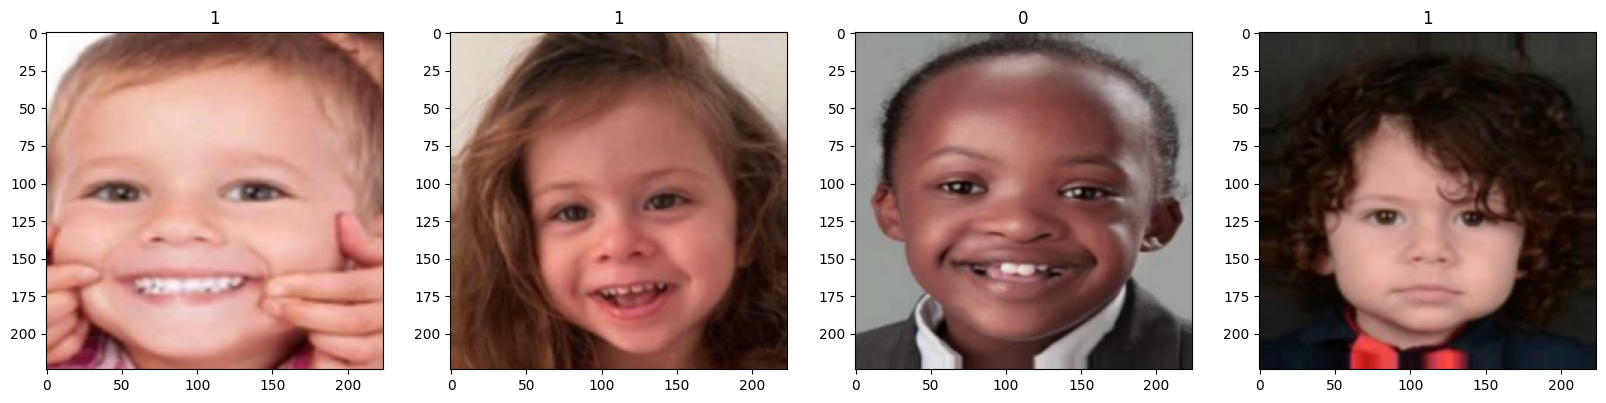

In [21]:
#Data visualization
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

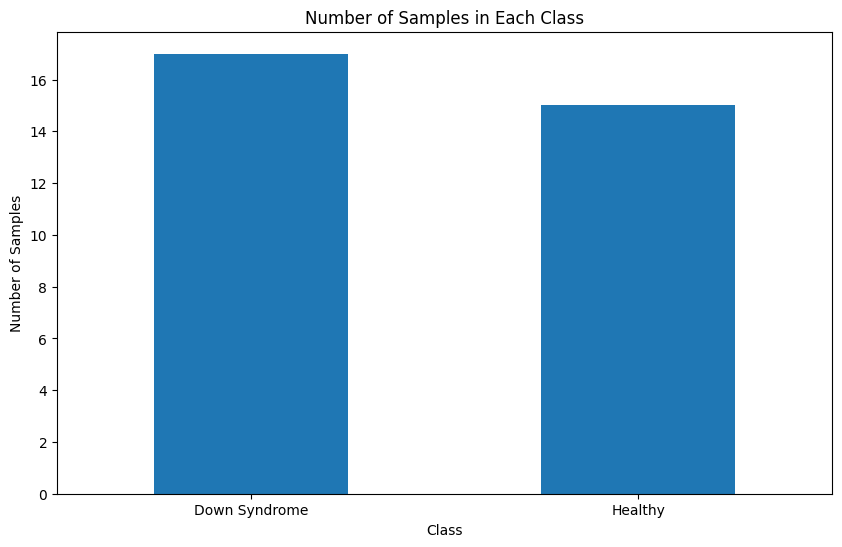

In [22]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1], columns=['Class'])

# Counting the number of samples in each class
class_counts = df_features['Class'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Number of Samples in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Down Syndrome', 'Healthy'], rotation=0)
plt.show()

In [23]:
class_counts

Class
0    17
1    15
Name: count, dtype: int64

In [24]:
#Data Preprocessing

#Data scaling
data = data.map(lambda x, y: (x / 255.0, y))  # Scale images to [0, 1]

# Verifying scaling
print(data.as_numpy_iterator().next()[0].min())  # Should print 0.0

0.0


In [25]:
#Checking lenght of dataset
len(data)

359

In [28]:
#Data splitting
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [29]:
#checking our data size
train_size,val_size, test_size

(251, 53, 53)

In [30]:
#Assigning suitable variable names
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [31]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def get_inceptionv3_model():
    # Load the InceptionV3 model with pre-trained ImageNet weights, excluding the top layers
    inceptionv3 = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(224, 224, 3))
    
    # Build the model with InceptionV3 as the base
    model = tf.keras.models.Sequential([
        inceptionv3,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create and build the InceptionV3 model
spoofnet = get_inceptionv3_model()
spoofnet.build(input_shape=(None, 224, 224, 3))  # Specify batch size as None for flexibility
spoofnet.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,854,433 (87.18 MB)

 Trainable params: 22,818,977 (87.05 MB)

 Non-trainable params: 35,456 (138.50 KB)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

checkpoint = ModelCheckpoint(filepath='spoffnet.keras',  # changed '.h5' to '.keras'
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='loss'  # changed 'val_loss' to 'loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='loss',  # changed 'val_loss' to 'loss'
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('train.log')

callbacks = [checkpoint, reduce_lr, csv_logger]


In [38]:
# Fit the model with appropriate steps
hist = spoofnet.fit(
    train,
    validation_data=val,
    callbacks=callbacks,
    epochs=5
)

Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9847 - loss: 0.0419
Epoch 1: loss improved from 0.04081 to 0.03456, saving model to spoffnet.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.9847 - loss: 0.0419 - val_accuracy: 0.9876 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9916 - loss: 0.0229
Epoch 2: loss improved from 0.03456 to 0.02335, saving model to spoffnet.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 182ms/step - accuracy: 0.9916 - loss: 0.0229 - val_accuracy: 0.9929 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9920 - loss: 0.0232
Epoch 3: loss did not improve from 0.02335
251/251 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.9920 - loss: 0.0232 - val_accuracy: 0.9841 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9931 - loss: 0.0201
Epoch 4: loss impro

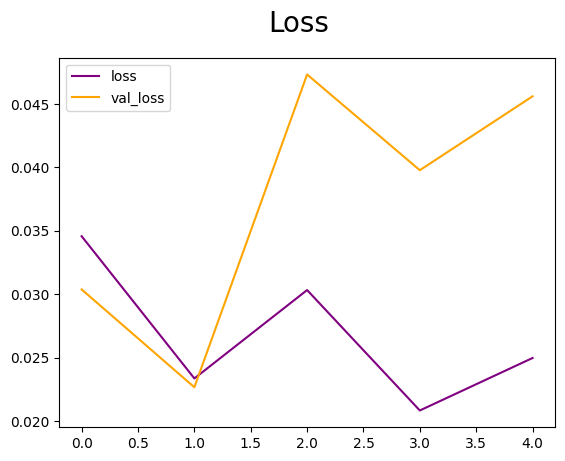

In [39]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='purple', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

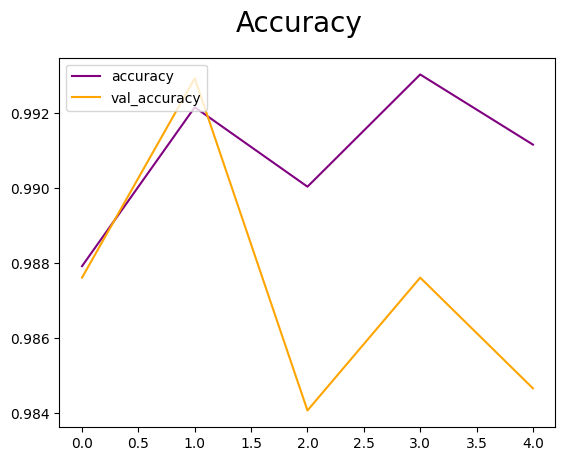

In [40]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='purple', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

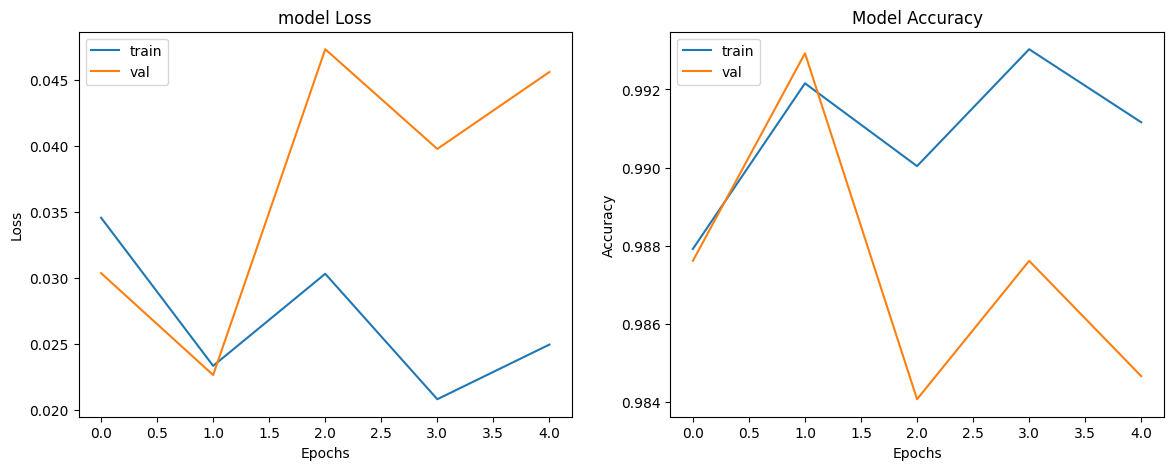

In [41]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [42]:
_, accu = spoofnet.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9845 - loss: 0.0451
Final Test Accuracy = 98.408%


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

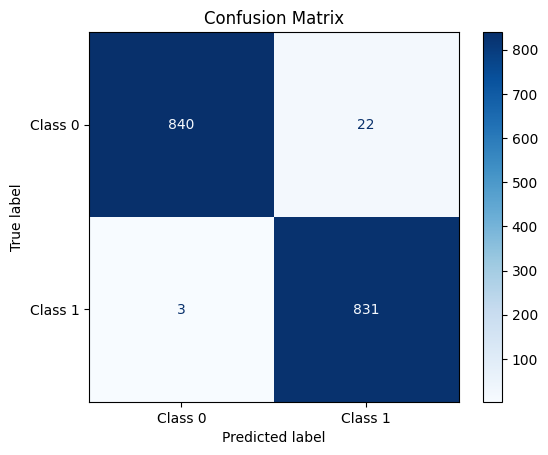

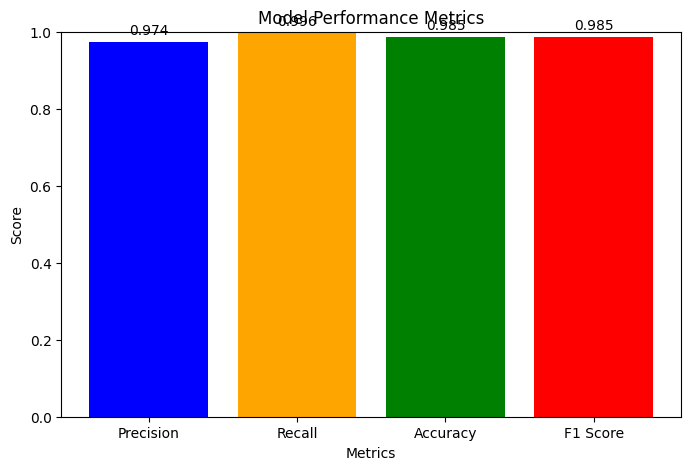

In [43]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict labels for the test set
true_labels = []
pred_labels = []

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = spoofnet.predict(images)  # Replace with your model name if different
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)



# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Plotting the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()

In [45]:
teacher=spoofnet

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense

# Instantiate the Sequential model
student_scratch = Sequential()

# Adding the convolutional layers
student_scratch.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.3))  

student_scratch.add(Conv2D(64, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.4))  

student_scratch.add(Conv2D(128, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.4))  

student_scratch.add(Conv2D(256, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.5))  

# Global Average Pooling instead of Flatten
student_scratch.add(GlobalAveragePooling2D())  

# Fully connected layers
student_scratch.add(Dense(512, activation='relu'))  
student_scratch.add(Dropout(0.5))  

# Output layer
student_scratch.add(Dense(1, activation='sigmoid'))  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
# Compiling the model
student_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Printing a summary of the model architecture
student_scratch.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,433 (1.99 MB)

 Trainable params: 521,473 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [49]:
logdir = 'logs2'  # Directory where TensorBoard logs will be saved
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  # Callback to log training process for TensorBoard

In [50]:
# Train the model with the profiler callback
history = student_scratch.fit(train, epochs=50, validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/50


I0000 00:00:1730910961.516647     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads



251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.7005 - loss: 0.5927 - val_accuracy: 0.4900 - val_loss: 0.8113
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.7499 - loss: 0.5151 - val_accuracy: 0.5472 - val_loss: 0.7729
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.7744 - loss: 0.4724 - val_accuracy: 0.6952 - val_loss: 0.5913
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.7956 - loss: 0.4381 - val_accuracy: 0.6769 - val_loss: 0.6426
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.8042 - loss: 0.4226 - val_accuracy: 0.5212 - val_loss: 1.7161
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.8308 - loss: 0.3889 - val_accuracy: 0.6651 - val_loss: 0.9001
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.8464 - loss: 0.3443 - val_accuracy: 0.7300 - val_loss: 0.5389
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.8698 - loss: 0.3096 - val_accurac

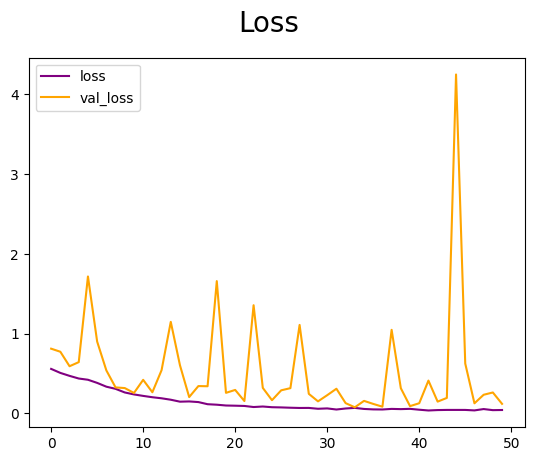

In [51]:
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

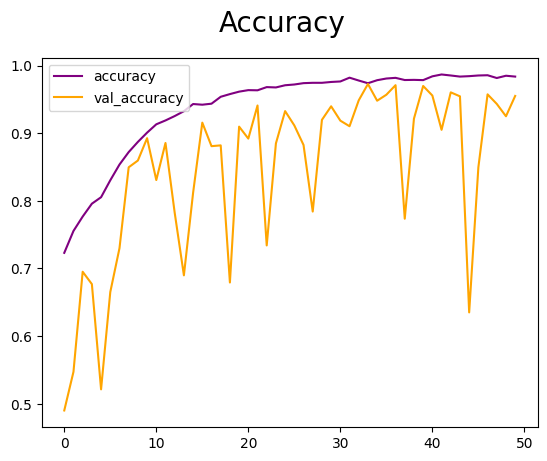

In [52]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='purple', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [53]:
_, accu = student_scratch.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9486 - loss: 0.1362
Final Test Accuracy = 95.696%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

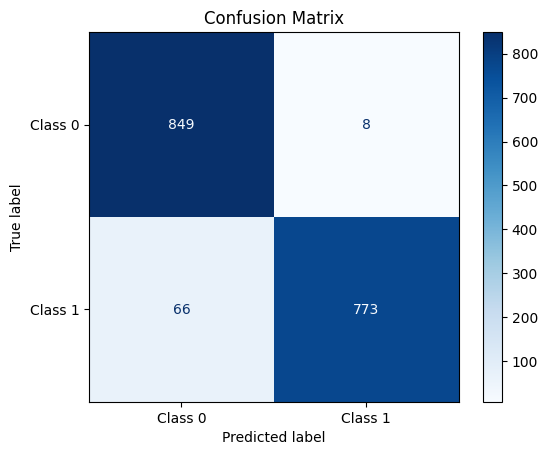

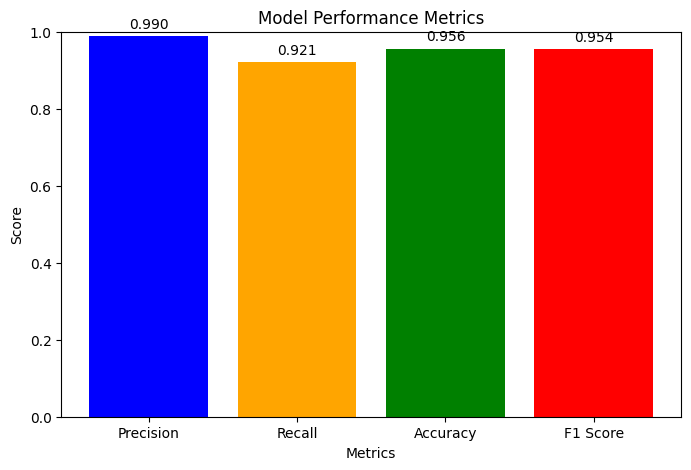

In [54]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict labels for the test set
true_labels = []
pred_labels = []

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = student_scratch.predict(images)  # Replace with your model name if different
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)



# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Plotting the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()